# Exploring Grid Flexibility

This data exploration is inspired by Saul Griffith's Electrify: "Electrifying the whole household roughly triples the amount of electricity it requires...While this might initially seem like a problem, adding thermal loads and connecting electric vehicles to the house provides greater opportunity for these machines to take turns sucking up some sunshine." (p.88)

As an engineer learning about the energy space, the goal of this project is to faciliate conversations with folks who are dealing with these problems in their day-to-day work, and to start digging into some of the freely available data and simple algorithms we can apply to them.

The final "allocated resources" chart is inspired by Griffith's flexible load profile chart on page 89. I attempt to get close to it algorithmically, by following these steps:

1. Obtain and chart price data for a given day in New York's Genese region
2. Average out the price in one-hour "chunks" - as the data is orginally in 5 minute intervals
3. Create a list of energy resources with corresponding priority and number of hours energy each needs
4. Write a simple algorithm that selects the lowest-cost chunks of time for each resource taking its priority into account
5. Chart the "allocated resource" results - expectation is that the higher cost hour-chunks remain unallocated

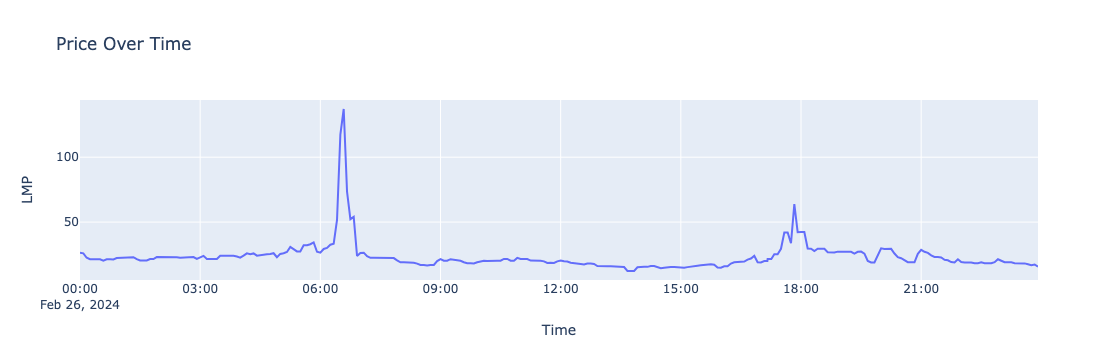

In [71]:
import gridstatus
import plotly.express as px
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display
from operator import itemgetter

def get_nyiso_price_data_by_location(date, location):
    nyiso = gridstatus.NYISO()
    lmp = nyiso.get_lmp(date=date, market="REAL_TIME_5_MIN")
    lmp_col_subset = lmp[["Time", "Location", "LMP"]]
    lmp_subset_filtered = lmp_col_subset[lmp_col_subset["Location"] == location]
    return lmp_subset_filtered

price_data_by_location = get_nyiso_price_data_by_location("February 26, 2024", "GENESE");

fig = px.line(price_data_by_location, x="Time", y="LMP", title="Price Over Time")
fig.show()

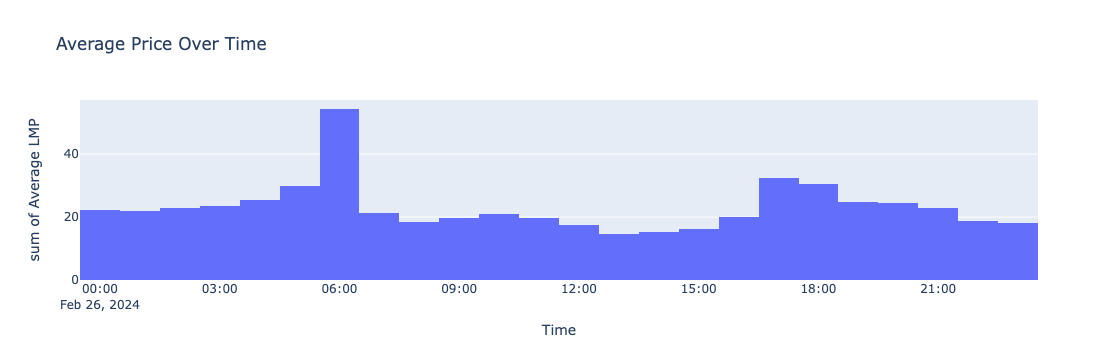

In [72]:
def get_data_averaged_by_hour(data_by_location, column_to_average):
    data_averaged_by_hour = [];
    num_chunks = len(data_by_location) / 12
    for chunk in np.array_split(data_by_location, num_chunks):
        data_averaged_by_hour.append([chunk["Time"].iloc[0], chunk.loc[:, column_to_average].mean()])
    return data_averaged_by_hour
    
price_data_averaged_by_hour = get_data_averaged_by_hour(price_data_by_location, "LMP")

num_chart_bins = len(price_data_averaged_by_hour)
price_data_averaged_by_hour_df = pd.DataFrame(price_data_averaged_by_hour, columns=["Time", "Average LMP"])
fig = px.histogram(price_data_averaged_by_hour_df, x="Time", y="Average LMP", title="Average Price Over Time", nbins = num_chart_bins)
fig.show()

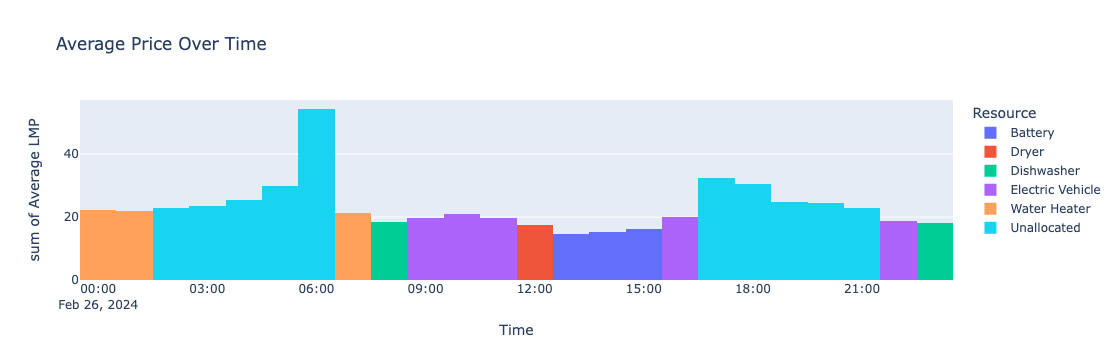

In [73]:
def get_resources():
    return [
        {"name": "Battery", "hours": 3, "priority": 1},
        {"name": "Dryer", "hours": 1, "priority": 2},
        {"name": "Dishwasher", "hours": 2, "priority": 3},
        {"name": "Electric Vehicle", "hours": 5, "priority": 4},
        {"name": "Water Heater", "hours": 3, "priority": 5},
    ]

def allocate_resources_by_price(resources, price_data_averaged_by_hour):
    # sort by price asc
    price_data_averaged_by_hour_sorted = sorted(price_data_averaged_by_hour, key=itemgetter(1))
    return allocate_resources(resources, price_data_averaged_by_hour_sorted)

def allocate_resources(resources, data_averaged_by_hour_sorted):
    # sort by priority asc
    resources_sorted = sorted(resources, key=itemgetter("priority"))
    allocated = []
    i = 0
    for resource in resources_sorted: 
        for hour in range(resource["hours"]):
            allocated.append([resource["name"],
                              data_averaged_by_hour_sorted[i][0], 
                              data_averaged_by_hour_sorted[i][1]])
            i += 1
            
    for rem_i in range(len(data_averaged_by_hour_sorted) - i):
        allocated.append(["Unallocated", 
                          data_averaged_by_hour_sorted[i + rem_i][0], 
                          data_averaged_by_hour_sorted[i + rem_i][1]])
    return allocated;

# allocate our resources to lowest price throughout day
resources = get_resources()
price_data_with_resources_allocated = allocate_resources_by_price(resources, price_data_averaged_by_hour)

resources_allocated = pd.DataFrame(price_data_with_resources_allocated, columns=["Resource", "Time", "Average LMP"])
num_chart_bins = len(resources_allocated)
fig = px.histogram(resources_allocated, x="Time", y="Average LMP", title="Average Price Over Time", color="Resource", nbins = num_chart_bins)
fig.show()

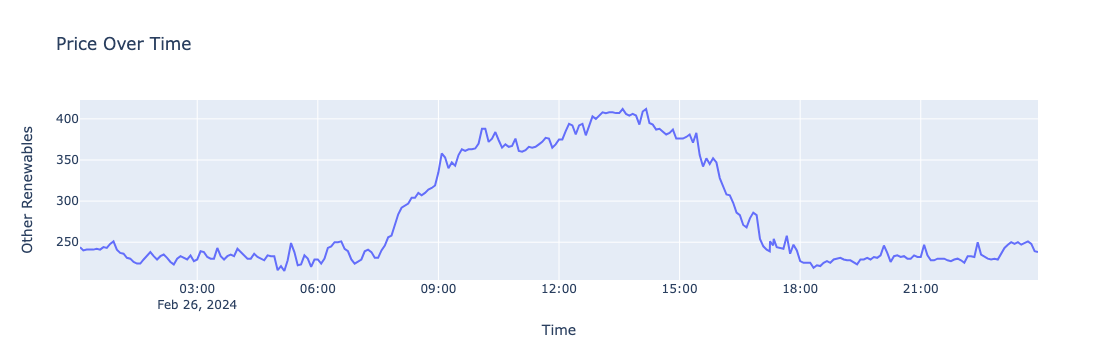

In [74]:
def get_energy_mix(date):
    nyiso = gridstatus.NYISO()
    mix = nyiso.get_fuel_mix(start=date, end="February 27, 2024")
    mp_col_subset = mix[["Time", "Other Renewables"]]
    lmp_subset_filtered = mp_col_subset[mp_col_subset["Time"] < "February 27, 2024"]
    return lmp_subset_filtered
    
energy_mix_data = get_energy_mix("February 26, 2024")
fig = px.line(mix, x="Time", y="Other Renewables", title="Price Over Time")
fig.show()

In [ ]:
"Solar Energy, Energy Storage Resources, Methane, Refuse, Wood"

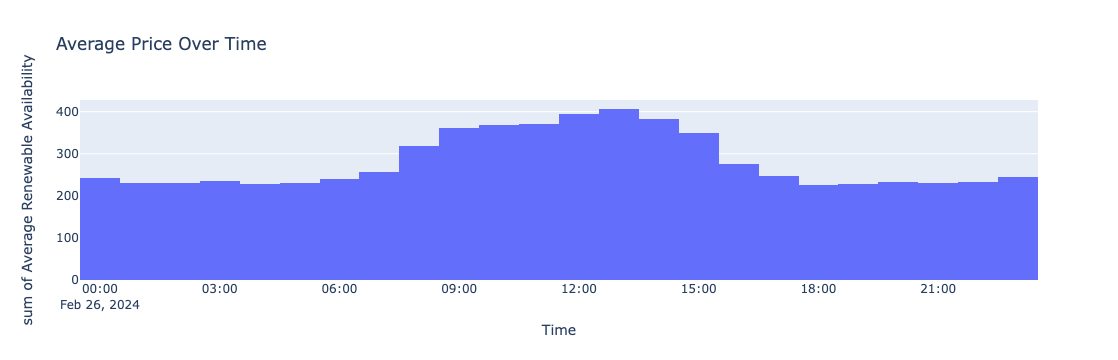

In [63]:
energy_mix_averaged_by_hour = get_data_averaged_by_hour(energy_mix_data, "Other Renewables")

num_chart_bins = len(energy_mix_averaged_by_hour)
energy_mix_averaged_by_hour_df = pd.DataFrame(energy_mix_averaged_by_hour, columns=["Time", "Average Renewable Availability"])
fig = px.histogram(energy_mix_averaged_by_hour_df, x="Time", y="Average Renewable Availability", title="Average Price Over Time", nbins = num_chart_bins)
fig.show()

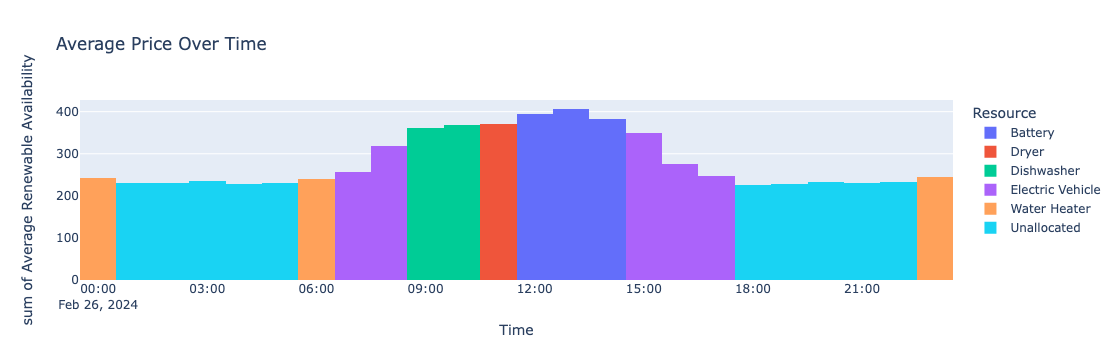

In [70]:
def allocate_resources_by_energy_availability(resources, energy_mix_averaged_by_hour):
    # sort by price asc
    energy_data_averaged_by_hour_sorted = sorted(energy_mix_averaged_by_hour, key=itemgetter(1), reverse=True)
    return allocate_resources(resources, energy_data_averaged_by_hour_sorted)

renewable_data_with_resources_allocated = allocate_resources_by_energy_availability(resources, energy_mix_averaged_by_hour)

resources_allocated = pd.DataFrame(renewable_data_with_resources_allocated, columns=["Resource", "Time", "Average Renewable Availability"])
num_chart_bins = len(resources_allocated)
fig = px.histogram(resources_allocated, x="Time", y="Average Renewable Availability", title="Average Price Over Time", color="Resource", nbins = num_chart_bins)
fig.show()